# Minimizing an ionic liquid pair in vacuum and comparing energy evaluations across engines

In this example, we will
1. Naively prepare a single ionic liquid cation-anion pair in (pseudo-)vacuum
2. Evaluate the energy of a structure using RDKit- or OEOmega-generated conformers using multiple engines
3. Energy-minimize the structure using OpenMM
4. Re-evaluate the energy with the same engines
5. Visualize each molecule with assigned partial charges

In [1]:
from openff.toolkit import Molecule, ForceField, Topology, Quantity
from openff.interchange.drivers.all import get_summary_data

DEPRECATION: --no-python-version-warning is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to remove the flag as it's a no-op. Discussion can be found at https://github.com/pypa/pip/issues/13154


To keep things simple, let's use BMIM-Tf2N, one of the most-studied ionic liquids.

The OpenFF toolkit works best when each molecule is loaded as a separate `Molecule` object in Python, so here we load the cation and anion separately before combining them into a single `Topology`. One could smoosh the two together into a single SMILES representation by simply concatenating with a `.`, but that can cause issues with some wrapped and downstream functionality.

For each ion, we'll load the molecule from a SMILES string and generate some conformers, just to get a sensible 3-D structure for a starting point. If working with `Molecule`s is new, a good place to start is the [cookbook](https://docs.openforcefield.org/projects/toolkit/en/stable/users/molecule_cookbook.html) provided in the OpenFF Toolkit docs. This also enables the default IPython/Jupyter visualzation to emit the 3-D structure using `NGLview` as a backend.

In [2]:
bmim = Molecule.from_smiles("CCCCN1C=C[N+](=C1)C")
bmim.generate_conformers()
bmim

NGLWidget(max_frame=1)

In [3]:
tf2n = Molecule.from_smiles("C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F")
tf2n.generate_conformers()
tf2n

NGLWidget(max_frame=1)

When we combine these `Molecule`s into a single `Topology`, we get keep the rich chemical representation of the constituent molecules. However, since each of our conformers were generated separately for each ion, they overlap. We can see this in the visualization `Topology.visualize()` - this isn't going to run sensibly in an MD engine.

In [4]:
topology = Topology.from_molecules([bmim, tf2n])
topology.visualize()

NGLWidget()

The quickest way to fix this is to simply move one of the conformers of a molecule by a small distance in space. Under the hood, `Topology.from_molecules` uses the _first_ conformer of each molecule's `Molecule.conformers` list, so we only need to modify the first one. The distance we move them is somewhat arbitrary, the values here seem to pass an eye check.

After modifying the first Tf2N conformer's positions, we can re-make the topology and visualize it to check that it looks more realistic. (It looks fine on my machine now, anyway!)

In [5]:
tf2n.conformers[0] += Quantity([0, 0, 4], "angstroms")

topology = Topology.from_molecules([bmim, tf2n])
topology.visualize()

NGLWidget()

Now let's see how a force field works with this ionic liquid! We'll take the most recent release in OpenFF's Sage force field line off the shelf and make an `Interchange` object out of it and the topology we just assembled.

One small quirk here is that we set the box vectors to be somewhat arbitrarily large; this is to trick simulation engines which do not properly support vacuum simulations to still do something like vacuum. It's not a perfect approximation, but setting the box vectors to more than twice the cutoff - Sage uses 9 Angstroms - makes things act mostly like they would in vacuum.

In [6]:
sage = ForceField("openff_unconstrained-2.2.1.offxml")
topology.box_vectors = Quantity([5, 5, 5], "nanometer")

interchange = sage.create_interchange(topology)

We are now working with an [`Interchange` object](https://docs.openforcefield.org/projects/interchange/en/stable/) - think of this like the result of applying a force field to a chemical topology, which it is!

We can do a lot of things with this, but for starters let's visualize it with `Interchange.visualize`. This should look approximately identical to the topology visualization we did before, just with some box vectors added in.

In [7]:
interchange.visualize()

NGLWidget()

One of Interchange's features is a set of functions which evaluate single-point energies with different simulation engines. By default, this iterates through OpenMM, Amber, GROMACS, and LAMMPS and skips over each one that's not installed. For each, it runs a 0-step "simulation" and reports back the potential energy split into different components. This is useful for validating Interchange's interface to each engine. There are separate functions for doing this in each engine, but we'll use a function `get_summary_data` which wraps _those_ functions and simply returns a dataframe of summary statistics.

In [8]:
summary = get_summary_data(interchange)
summary

/Users/mattthompson/micromamba/envs/il/lib/python3.12/site-packages/openff/interchange/components/mdconfig.py:401: SwitchingFunctionNotImplementedWarning: A switching distance 8.0 angstrom was specified by the force field, but Amber does not implement a switching function. Using a hard cut-off instead. Non-bonded interactions will be affected.
  warnings.warn(


,Bond,Angle,Torsion,Electrostatics,vdW,RBTorsion
OpenMM,18.966434,133.100572,29.927331,345.184421,11983.901659,NaN
Amber,18.966490,133.100571,29.927315,345.194644,11983.898572,NaN
GROMACS,18.966679,133.100449,29.927341,345.034981,11983.866796,0.0


As a spot-check, it looks like the engines agree to something like 1e-4 kJ/mol for each component, which is a good sign.

The result is simply a `pandas.DataFrame` object, so we can look at summary statistics with `.describe()`:

In [9]:
summary.describe()

,Bond,Angle,Torsion,Electrostatics,vdW,RBTorsion
count,3.000000,3.000000,3.000000,3.000000,3.000000,1.0
mean,18.966534,133.100531,29.927329,345.138015,11983.889009,0.0
std,0.000128,0.000071,0.000013,0.089377,0.019299,NaN
min,18.966434,133.100449,29.927315,345.034981,11983.866796,0.0
25%,18.966462,133.100510,29.927323,345.109701,11983.882684,0.0
50%,18.966490,133.100571,29.927331,345.184421,11983.898572,0.0
75%,18.966585,133.100572,29.927336,345.189533,11983.900116,0.0
max,18.966679,133.100572,29.927341,345.194644,11983.901659,0.0


Another feature of Interchange is a high-level method `Interchange.minimize` which wraps simulation engine(s) to run energy minimization. Right now, this is only implemented with an OpenMM backend.

In [10]:
interchange.minimize()

This method takes the resulting positions and modifies the `Interchange.positions` attribute in-place. In other words, the positions should now evaluate to a lower potential energy. But do they? Let's see:

In [11]:
get_summary_data(interchange).describe()

/Users/mattthompson/micromamba/envs/il/lib/python3.12/site-packages/openff/interchange/components/mdconfig.py:401: SwitchingFunctionNotImplementedWarning: A switching distance 8.0 angstrom was specified by the force field, but Amber does not implement a switching function. Using a hard cut-off instead. Non-bonded interactions will be affected.
  warnings.warn(


,Bond,Angle,Torsion,Electrostatics,vdW,RBTorsion
count,3.000000,3.000000,3.000000,3.000000,3.000000,1.0
mean,28.342500,57.025698,27.933771,150.083090,-13.861405,0.0
std,0.000118,0.000144,0.000115,0.036284,0.016403,NaN
min,28.342416,57.025543,27.933639,150.042633,-13.880002,0.0
25%,28.342432,57.025633,27.933738,150.068260,-13.867611,0.0
50%,28.342448,57.025723,27.933837,150.093887,-13.855221,0.0
75%,28.342541,57.025775,27.933838,150.103319,-13.852107,0.0
max,28.342634,57.025828,27.933838,150.112750,-13.848993,0.0


On my machine, the valence terms didn't change much (bond energies actually _increased_) but the non-bonded interactions descreased significatnly. In particular, the clashing intermolecular interactions were resolved and now we don't have vdW interactions dominating everything else by several orders of magnitude. Now, electrostatics dominate, at least numerically. This isn't a huge surprise - we already know that Coulombic interactions drive ionic liquid interactions more than similar neutral molecules, and there may have been some other bad energetics with the original conformers (which weren't generated with a force field in mind). We can go back to `Interchange.visualize` to look more closely at the result, and we see an intuitive result: the ring in BMIM+ (where the positive charge is distributed) likes to associate with the middle section of Tf2N- (where the negative charge is distributed) much more than with the alkyl tail or CF3 groups.

In [12]:
interchange.visualize()

NGLWidget()

# Appendix: Visualizing assigned charges

Sage had no ionic liquids in its training data, nor is its charge model (AM1-BCC) particularly suited to describing ionic liquids. If one takes for granted that the charge model is particularly important, the first step of a deep-dive might be to look at the partial charges assigned to each atom in each molecule. For the lazy among us, it's convenient to wrap this into a function.

In [13]:
from IPython.display import SVG
import rdkit.Chem

def draw_with_partial_charges(molecule: Molecule) -> SVG:
    """
    Adapted from one of several iterations written by Josh Mitchell, mostly recently in a pre-release version of OpenFF Pablo:
    https://github.com/openforcefield/openff-pablo/blob/f08589e025104ac0e6a2184477f948a6c2de0886/openff/pablo/_utils.py#L276
    """
    rdmol = rdkit.Chem.rdchem.Mol(molecule.to_rdkit())

    rdkit.Chem.rdmolops.Kekulize(rdmol, clearAromaticFlags=True)
    rdkit.Chem.rdDepictor.Compute2DCoords(rdmol)

    for index in range(molecule.n_atoms):
        rdatom = rdmol.GetAtomWithIdx(index)
        rdatom.SetProp(
            "atomNote",
            str(
                round(
                    molecule.partial_charges[index].m,
                    2,
                )
            ),
        )

    drawer = rdkit.Chem.Draw.MolDraw2DSVG(500, 500)
    
    draw_options = drawer.drawOptions()
    draw_options.useDefaultAtomPalette()
    
    drawer.DrawMolecule(
        rdmol,
    )

    drawer.FinishDrawing()

    return SVG(drawer.GetDrawingText())

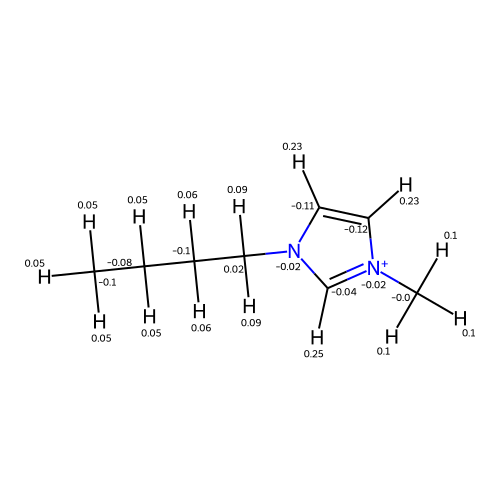

In [14]:
bmim.assign_partial_charges(partial_charge_method="am1bcc")

draw_with_partial_charges(bmim)

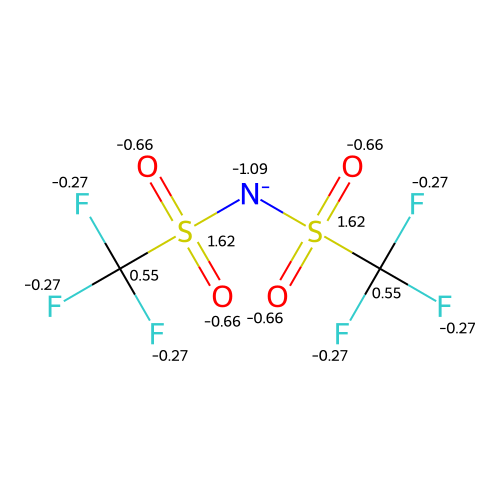

In [15]:
tf2n.assign_partial_charges(partial_charge_method="am1bcc")

draw_with_partial_charges(tf2n)